In [275]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

In [276]:
df = pd.read_csv('../dataset/cleaned_NEM.csv')

In [277]:
# Flip the column
df = df.iloc[::-1]

# Reset the index
df = df.reset_index(drop=True)

In [278]:
df

,Date,Adj Close,Close,High,Low,Open,Volume
0,11/5/2024,46.000000,46.000000,46.130001,45.669998,45.799999,6789100
1,11/4/2024,45.759998,45.759998,45.889999,45.130001,45.389999,8656200
2,11/1/2024,45.259998,45.259998,46.009998,45.090000,45.389999,11049000
3,10/31/2024,45.439999,45.439999,46.450001,45.180000,46.349998,13809400
4,10/30/2024,46.939999,46.939999,47.580002,46.509998,47.439999,11956500
...,...,...,...,...,...,...,...
1467,1/8/2019,28.097637,34.070000,34.080002,33.389999,33.630001,6457200
1468,1/7/2019,28.015163,33.970001,34.930000,33.799999,34.669998,4868600
1469,1/4/2019,28.353298,34.380001,34.490002,33.279999,33.910000,8622600
1470,1/3/2019,28.353298,34.380001,34.869999,34.049999,34.740002,5763200


# SPLITTING DATA(7-2-1)

In [279]:
# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [280]:
# Training process

x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', stepwise=True, suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3164.917, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3157.991, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3159.328, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3159.331, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3156.197, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3160.949, Time=0.44 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.370 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [281]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [282]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)


Predicted closing prices for the next 30 days:
[62.29000092 62.29000092 62.29000092 62.29000092 62.29000092 62.29000092
 62.29000092 62.29000092 62.29000092 62.29000092 62.29000092 62.29000092
 62.29000092 62.29000092 62.29000092 62.29000092 62.29000092 62.29000092
 62.29000092 62.29000092 62.29000092 62.29000092 62.29000092 62.29000092
 62.29000092 62.29000092 62.29000092 62.29000092 62.29000092 62.29000092]


In [283]:
# Evaluating algorithm accuracy using
#RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val)**2))
print('Testing RMSE:', test_rmse)
print('Validation RMSE:', valid_rmse)

#MAE
from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
valid_mae = mean_absolute_error(y_val, y_pred_val)
print('Testing MAE:', test_mae)
print('Validation MAE:', valid_mae)

#MAPE
from sklearn.metrics import mean_absolute_percentage_error
test_mape = mean_absolute_percentage_error(y_test, y_pred)
valid_mape = mean_absolute_percentage_error(y_val, y_pred_val)
print('Testing MAPE:', test_mape)
print('Validation MAPE:', valid_mape)

Testing RMSE: 16.290428924257444
Validation RMSE: 27.814588374739934
Testing MAE: 13.459218085748299
Validation MAE: 27.693311747229732
Testing MAPE: 0.31944337791343436
Validation MAPE: 0.8105806414384399


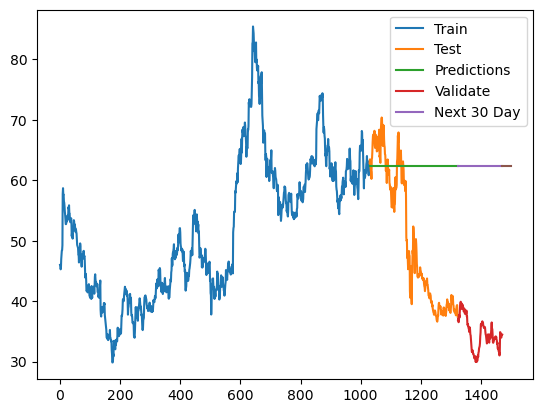

In [284]:
# Plot
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, val_data['Close'])
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next 30 Day'])
plt.show()

In [285]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1030
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1577.098
Date:                Thu, 07 Nov 2024   AIC                           3156.197
Time:                        18:10:57   BIC                           3161.133
Sample:                             0   HQIC                          3158.070
                               - 1030                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.2554      0.028     45.402      0.000       1.201       1.310
===================================================================================
Ljung-Box (L1) (Q):                   0.67   Jarque-Bera (JB):              1583.57
Prob(Q):                              0.41   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                             0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# SPLITTING DATA(6-3-1)

In [286]:
# Split the data into training, testing, and validation sets
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [287]:
# Training process
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2683.552, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2684.570, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2684.600, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2681.881, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2685.788, Time=0.34 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.231 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [288]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [289]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[64.83999634 64.83999634 64.83999634 64.83999634 64.83999634 64.83999634
 64.83999634 64.83999634 64.83999634 64.83999634 64.83999634 64.83999634
 64.83999634 64.83999634 64.83999634 64.83999634 64.83999634 64.83999634
 64.83999634 64.83999634 64.83999634 64.83999634 64.83999634 64.83999634
 64.83999634 64.83999634 64.83999634 64.83999634 64.83999634 64.83999634]


In [290]:
# Calculate accurary for each model
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) 
val_mape = np.mean(val_ape)

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  15.120653262652452
Testing MAE:  11.347434921111109
Testing MAPE:  0.2607641544361269
Validation RMSE:  30.35439736411143
Validation MAE:  30.243307167229727
Validation MAPE:  0.8847012430601726


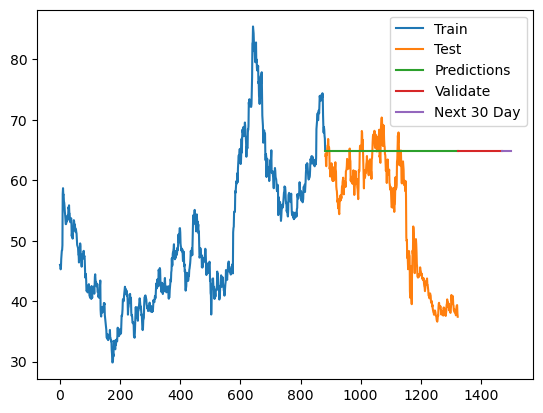

In [291]:
# Plot
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next 30 Day'])
plt.show()

# SPLITTING DATA(5-3-2)

In [292]:
# Split the data into training, testing, and validation sets
train_size = int(0.5 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [293]:
# Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Close'])

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2285.086, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2277.903, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2279.666, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2279.672, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2275.958, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2281.131, Time=0.44 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.017 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [294]:
# Testing process
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Close'])
y_pred = model.predict(n_periods=len(y_test))

# Validation process
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['Close'])
y_pred_val =  model.predict(n_periods=len(y_val))

In [295]:
# Create index predict for next 30 days
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[53.27000046 53.27000046 53.27000046 53.27000046 53.27000046 53.27000046
 53.27000046 53.27000046 53.27000046 53.27000046 53.27000046 53.27000046
 53.27000046 53.27000046 53.27000046 53.27000046 53.27000046 53.27000046
 53.27000046 53.27000046 53.27000046 53.27000046 53.27000046 53.27000046
 53.27000046 53.27000046 53.27000046 53.27000046 53.27000046 53.27000046]


In [296]:
# Calculate accuracy for each model
from sklearn.metrics import mean_squared_error
test_mse = mean_squared_error(y_test, y_pred)
val_mse = mean_squared_error(y_val, y_pred_val)
test_rmse = np.sqrt(test_mse)
val_rmse = np.sqrt(val_mse)

from sklearn.metrics import mean_absolute_error
test_mae = mean_absolute_error(y_test, y_pred)
val_mae = mean_absolute_error(y_val, y_pred_val)

test_ape = np.abs((y_test - y_pred) / y_test)
val_ape = np.abs((y_val - y_pred_val) / y_val)
test_mape = np.mean(test_ape) 
val_mape = np.mean(val_ape) 

print('Testing RMSE: ', test_rmse)
print('Testing MAE: ', test_mae)
print('Testing MAPE: ', test_mape)
print('Validation RMSE: ', val_rmse)
print('Validation MAE: ', val_mae)
print('Validation MAPE: ', val_mape)

Testing RMSE:  9.357464189803222
Testing MAE:  8.2209972007483
Testing MAPE:  0.1318042147514209
Validation RMSE:  16.153529719032566
Validation MAE:  15.584983517559325
Validation MAPE:  0.43122024310561186


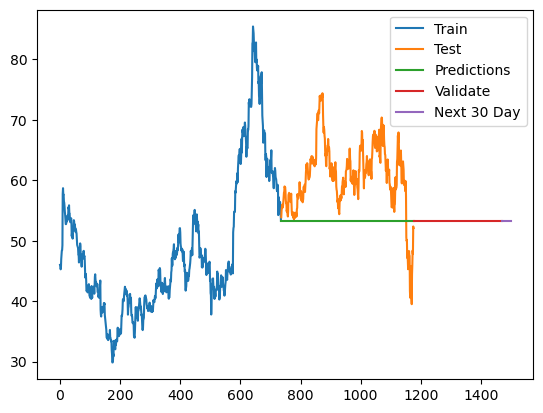

In [297]:
# Plot
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next 30 Day'])
plt.show()

# Comparison

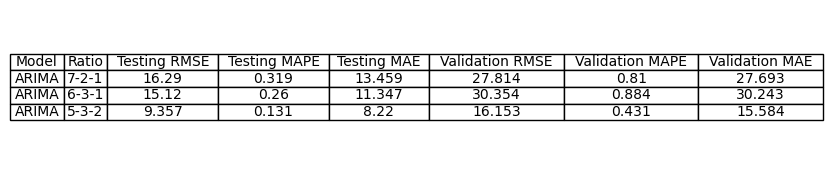

In [298]:
# Define the corrected data for the evaluation table
evaluation_data_corrected = {
    "Model": ["ARIMA", "ARIMA", "ARIMA"],
    "Ratio": ["7-2-1", "6-3-1", "5-3-2"],
    "Testing RMSE": [16.290, 15.120, 9.357],
    "Testing MAPE": [0.319, 0.260, 0.131],
    "Testing MAE": [13.459, 11.347, 8.220],
    "Validation RMSE": [27.814, 30.354, 16.153],    
    "Validation MAPE": [0.810, 0.884, 0.431],
    "Validation MAE": [27.693, 30.243, 15.584]
}

# Create a DataFrame from the corrected data
evaluation_df_corrected = pd.DataFrame(evaluation_data_corrected)

# Plot the corrected table using matplotlib
fig, ax = plt.subplots(figsize=(10, 2))  # Adjust size as needed
ax.axis('off')  # Hide the axis

# Render the corrected table
table = ax.table(cellText=evaluation_df_corrected.values, colLabels=evaluation_df_corrected.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(evaluation_df_corrected.columns))))  # Adjust width of each column

# Save the corrected table as an image
corrected_table_image_path = '../ComparisonModel/ARIMA/NEM.png'
plt.savefig(corrected_table_image_path, bbox_inches='tight', dpi=300)
plt.show()
